In [1]:
### 1. Find suitable dataset with a target
### 2. Clean Data
### 3. Explore data, find correlation between features and target, and features and features
### 4. Feature Engineering find good features
### 5. Try multiple models or multiple sets of different features
### 6. Tune hyperparameters if applicable
### 7. Compare models and choose best one and explain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
df = pd.read_csv("student_depression_dataset.csv")

def plot_categorical_counts(category_col):
    plt.figure(figsize=(20, 15))
    
    # Create a contingency table (cross-tabulation)
    cross_tab = pd.crosstab(df[category_col], df['Depression'])

    # Plot the bar graph
    ax = cross_tab.plot(kind='bar', stacked=False)
    plt.title(f'Counts of {category_col} by Depression')
    plt.xlabel(category_col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Depression')

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')
    
    plt.show()

In [6]:
# df.info()
df.head()
# df.corr()

,Gender,Age,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Education
0,Male,33.0,5.0,8.97,2.0,'5-6 hours',Healthy,Yes,3.0,1.0,No,1,University
1,Female,24.0,2.0,5.90,5.0,'5-6 hours',Moderate,No,3.0,2.0,Yes,0,University
2,Male,31.0,3.0,7.03,5.0,'Less than 5 hours',Healthy,No,9.0,1.0,Yes,0,University
3,Female,28.0,3.0,5.59,2.0,'7-8 hours',Moderate,Yes,4.0,5.0,Yes,1,University
4,Female,25.0,4.0,8.13,3.0,'5-6 hours',Moderate,Yes,1.0,1.0,No,0,University


In [4]:
### clean -> explore

# Drop id work pressure, and job satisfaction as they do not contain any data
df = df.drop('id', axis = 1)
df = df.drop('Work Pressure', axis = 1)
df = df.drop('Job Satisfaction', axis = 1)

# Drop all non student rows then drop that column, 99% of data is student data
df = df[df['Profession'] == 'Student']
df = df.drop('Profession', axis = 1)

# Drop 'Others' rows essentially non existent data
df = df[df['Sleep Duration'] != 'Others']
df = df[df['Dietary Habits'] != 'Others']
df = df[df['Degree'] != 'Others']

In [ ]:
### clean -> explore

plot_categorical_counts('Gender')
plot_categorical_counts('City')
plot_categorical_counts('Sleep Duration')
plot_categorical_counts('Dietary Habits')
plot_categorical_counts('Degree')
plot_categorical_counts('Have you ever had suicidal thoughts ?')
plot_categorical_counts('Family History of Mental Illness')

In [5]:
### clean -> explore

# Quarter of data is class 12 and of the remaining university data it is primarily 50-55% with some 56-59%
# This is already a bloated categorical column so we are going to group all degrees together for the purposes 
# of this analysis. We can then use this as a binary column later.
#df['Education'] = pd.Series(dtype = 'string')

df['Education'] = df['Degree'].where(df['Degree'].eq("'Class 12'"), 'University')
df['Education'] = df['Education'].replace("'Class 12'", 'High School')
df = df.drop('Degree', axis = 1)
df = df.drop('City', axis = 1)

# Make Financial Stress a numeric field
df['Financial Stress'] = pd.to_numeric(df['Financial Stress'], errors = 'coerce')

df.dropna()
df['Financial Stress'] = df['Financial Stress'].fillna(df['Financial Stress'].mean())

In [ ]:
### explore

df_dep = df[df['Depression'] == 1]
df_no_dep = df[df['Depression'] == 0] 

plt.hist(df_dep['Age'])
plt.hist(df_no_dep['Age'], alpha = 0.5)
plt.title('Age')
plt.show()

plt.hist(df_dep['Academic Pressure'])
plt.hist(df_no_dep['Academic Pressure'], alpha = 0.5)
plt.title('Academic Pressure')
plt.show()

plt.hist(df_dep['CGPA'])
plt.hist(df_no_dep['CGPA'], alpha = 0.5)
plt.title('CGPA')
plt.show()

plt.hist(df_dep['Study Satisfaction'])
plt.hist(df_no_dep['Study Satisfaction'], alpha = 0.5)
plt.title('Study Satisfaction')
plt.show()

plt.hist(df_dep['Work/Study Hours'])
plt.hist(df_no_dep['Work/Study Hours'], alpha = 0.5)
plt.title('Work/Study Hours')
plt.show()

plt.hist(df_dep['Financial Stress'])
plt.hist(df_no_dep['Financial Stress'], alpha = 0.5)
plt.title('Financial Stress')
plt.show()


In [ ]:
# Explore -> Models

# For categorical columns we will initially include all but city. 
# For numeric columns we will include all but cgpa. The other five fields all seem to have notable correlation to depression so
# it makes sense to include all in the model for now.

In [ ]:
# Start with linear regression looking at numeric fields.

Y = df['Depression']
X = df[['Age', 'Academic Pressure', 'Study Satisfaction', 'Work/Study Hours', 'Financial Stress']]
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 37)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [ ]:
### OLS 

lrm = LinearRegression()
lrm.fit(X_train, y_train)
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [ ]:
# Lasso

lassoregr = LassoCV(alphas = alphas, cv = 5) 
lassoregr.fit(X_train, y_train)
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [ ]:
# Ridge

ridgeregr = RidgeCV(alphas = alphas, cv = 5) 
ridgeregr.fit(X_train, y_train)
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [ ]:
df.info()

[0.77202445 0.79359942 0.78892485 0.78101402 0.78820568 0.78345324
 0.77194245 0.7823741  0.7794964  0.77733813]



<AxesSubplot: >

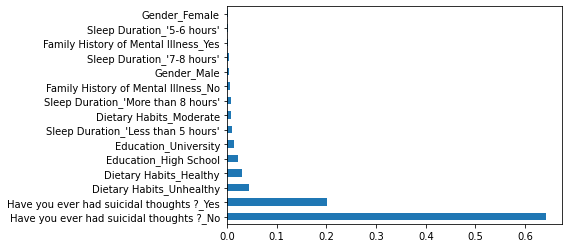

In [7]:
# Random Forest

df_cat = df.select_dtypes(include = ['object'])
rfc = ensemble.RandomForestClassifier(n_estimators = 10, n_jobs = -1)
X = df_cat
Y = df['Depression']
X = pd.get_dummies(X)

print(f'{cross_val_score(rfc, X, Y, cv = 10)}\n')

rfc.fit(X, Y)

feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [9]:
# Random Forest estimated accuracy is about 78% notably higher than the linear regression models using our numeric fields. 
# Top three impactful fields are Thoughts, Dietery Habits, and Education. Add these fields along with numeric fields to see
# if that produces better or worse results.

df_dummies = pd.get_dummies(df, columns = ['Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Education'])
df = pd.concat([df, df_dummies], axis=1)
dummy_column_names = ['Have you ever had suicidal thoughts ?_Yes', 'Education_High School', 'Education_University', 'Dietary Habits_Healthy', 'Dietary Habits_Moderate', 'Dietary Habits_Unhealthy', 'Have you ever had suicidal thoughts ?_No']
Y = df['Depression']
X = df[['Age', 'Academic Pressure', 'Study Satisfaction', 'Work/Study Hours', 'Financial Stress'] + dummy_column_names]
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 37)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [10]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.5132229812831306
-----Test set statistics-----
R-squared of the model in the test set is: 0.5164569084308532
Mean absolute error of the prediction is: 0.2689817877815602
Mean squared error of the prediction is: [0.11718498 0.11718498]
Root mean squared error of the prediction is: [0.34232291 0.34232291]
Mean absolute percentage error of the prediction is: Depression    inf
Depression    inf
dtype: float64


In [ ]:
# Random Forest produced a higher estimated accuracy still at 78% compared to an rsqsuared 51% above using linear regression with numeric 
# fields plus the three categorical fields. That model was an improvement from before increasing the rsquared by about 20% and
# lowering the mean value errors. I would still stick with random forest.